<h1>Spacial density of Na and K in various traps</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from typing import Union

from quantum_statistics.spatial_basis import GridSpatialBasisSet

from quantum_statistics import (
    ParticleProps, 
    BoseGas, 
    FermiGas, 
    harmonic_trap,
    box_trap,
    box_2d_harmonic_1d_trap,
    ring_beam_trap,
    analyze_bec,
    analyze_fermi_gas,
    plot_condens_frac,
)

In [2]:
grid = GridSpatialBasisSet(
    domain=(-120, 120) * u.um,
    num_grid_points=101,
)

grid2 = GridSpatialBasisSet(
    domain=(-120, 120) * u.um,
    num_grid_points=101,
    potential_function=harmonic_trap,
)

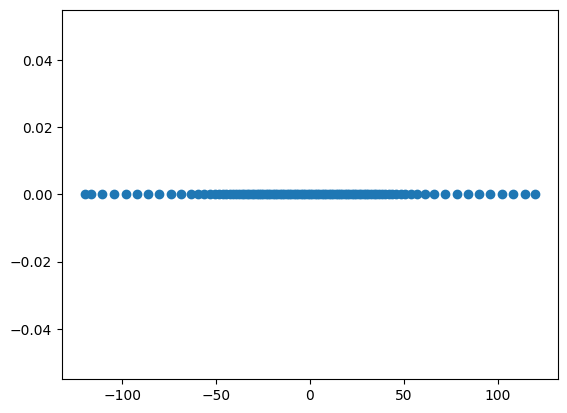

In [3]:
plt.scatter(grid2.grid_points_x, [0 for _ in grid2.grid_points_x])

In [4]:
coeffs = grid.get_coeffs(harmonic_trap)
coeffs2 = grid2.get_coeffs(harmonic_trap)

In [5]:
V = coeffs.reshape(grid.num_grid_points[0], grid.num_grid_points[1], grid.num_grid_points[2])
V2 = coeffs2.reshape(grid2.num_grid_points[0], grid2.num_grid_points[1], grid2.num_grid_points[2])

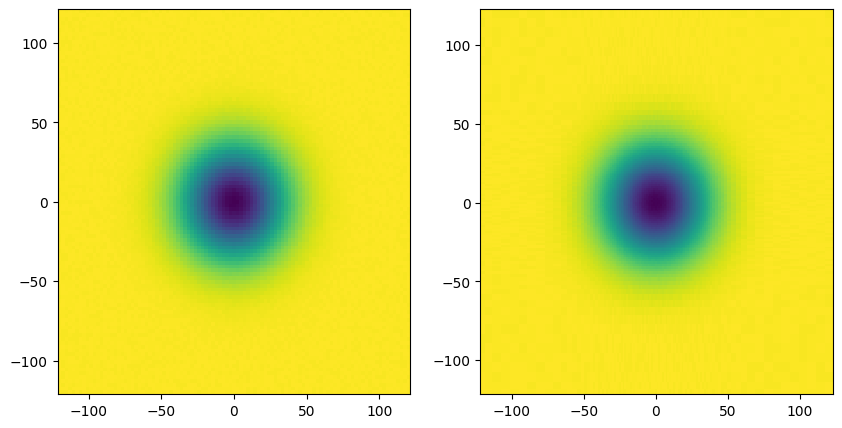

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].pcolormesh(grid.grid_points_x.value, grid.grid_points_y.value, V[:, :, grid.num_grid_points[2]//2])
axs[1].pcolormesh(grid2.grid_points_x.value, grid2.grid_points_y.value, V2[:, :, grid2.num_grid_points[2]//2])

In [7]:
integ = grid.integral(coeffs)
integ2 = grid2.integral(coeffs2)

In [8]:
integ, integ2

(<Quantity -35398735.25914858 um3>, <Quantity -35444195.57478829 um3>)

In [9]:
grad1 = grid.gradient(coeffs)
grad2 = grid2.gradient(coeffs2)

In [10]:
grad1.shape, grad2.shape

((1030301, 3), (1030301, 3))

In [11]:
grad1 = grad1.reshape(grid.num_grid_points[0], grid.num_grid_points[1], grid.num_grid_points[2], 3)
grad2 = grad2.reshape(grid2.num_grid_points[0], grid2.num_grid_points[1], grid2.num_grid_points[2], 3)

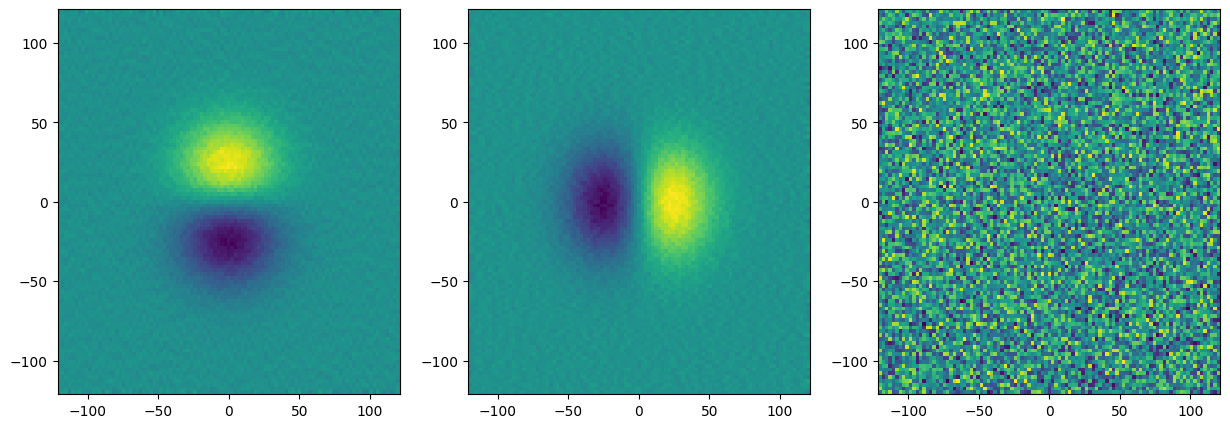

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].pcolormesh(grid.grid_points_x.value, grid.grid_points_y.value, grad1[:, :, grid.num_grid_points[2]//2, 0])
axs[1].pcolormesh(grid.grid_points_x.value, grid.grid_points_y.value, grad1[:, :, grid.num_grid_points[2]//2, 1])
axs[2].pcolormesh(grid.grid_points_x.value, grid.grid_points_y.value, grad1[:, :, grid.num_grid_points[2]//2, 2])

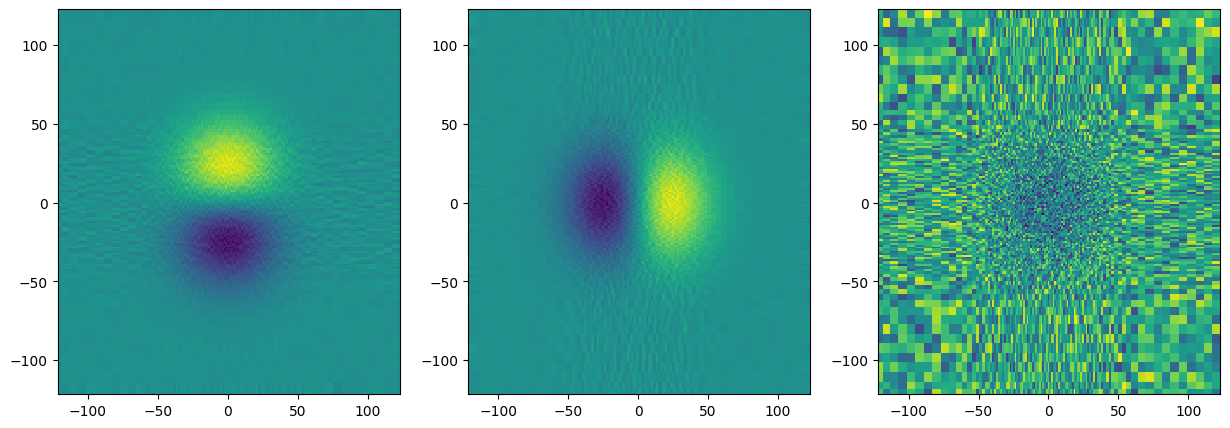

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].pcolormesh(grid2.grid_points_x.value, grid2.grid_points_y.value, grad2[:, :, grid2.num_grid_points[2]//2, 0])
axs[1].pcolormesh(grid2.grid_points_x.value, grid2.grid_points_y.value, grad2[:, :, grid2.num_grid_points[2]//2, 1])
axs[2].pcolormesh(grid2.grid_points_x.value, grid2.grid_points_y.value, grad2[:, :, grid2.num_grid_points[2]//2, 2])

In [14]:
lap = grid.laplacian(coeffs)
lap2 = grid2.laplacian(coeffs2)

lap3d = lap.reshape(grid.num_grid_points[0], grid.num_grid_points[1], grid.num_grid_points[2])
lap3d2 = lap2.reshape(grid2.num_grid_points[0], grid2.num_grid_points[1], grid2.num_grid_points[2])

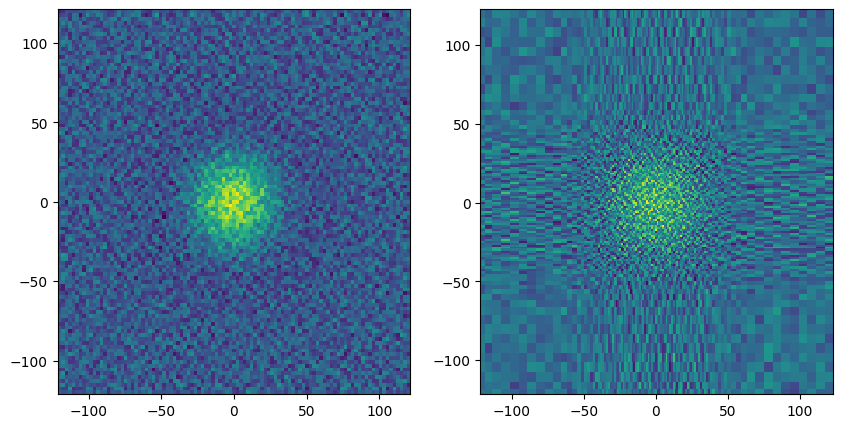

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].pcolormesh(grid.grid_points_x.value, grid.grid_points_y.value, lap3d[:, :, grid.num_grid_points[2]//2])
axs[1].pcolormesh(grid2.grid_points_x.value, grid2.grid_points_y.value, lap3d2[:, :, grid2.num_grid_points[2]//2])

In [16]:
x = np.linspace(grid.domain[0, 0], grid.domain[0, 1], 501)
y = np.linspace(grid.domain[1, 0], grid.domain[1, 1], 501)
z = 0

X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

fun = grid.expand_coeffs(coeffs, X, Y, Z)
fun2 = grid2.expand_coeffs(coeffs2, X, Y, Z)

In [17]:
fun.shape

(501, 501, 1)

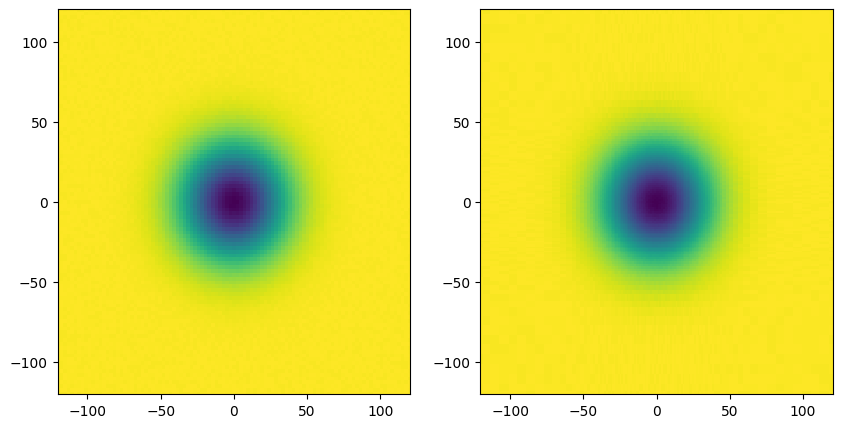

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].pcolormesh(x, y, fun[:, :, 0])
axs[1].pcolormesh(x, y, fun2[:, :, 0])
#axs[1].imshow(fun2[:, :, 0])

In [19]:
xs = grid2.grid_points_x
x = 0 * u.um
idx = np.digitize(x, xs) 

xs[idx], xs[idx+1], x

(<Quantity 1.22885691 um>, <Quantity 2.45905995 um>, <Quantity 0. um>)

In [20]:
blue_trap_hight_K = 250*u.nK   # for Na: *3
red_trap_depth_K = 17*100*u.nK # for Na: /17

k40_harmonic = ParticleProps(
    name="K40",
    species="fermion",
    m=39.963999*u.u,
    N_particles=200000,
    T=45*u.nK,
    domain=(-70, 70)*u.um,
    V_trap=harmonic_trap,
    #V_trap=box_trap,
    #V_trap=box_2d_harmonic_1d_trap,
    trap_depth=17*100,
    #box_width=(100,100,100),
    waist=50,
    #V_trap=ring_beam_trap,
    #flat_sizes=(100, 100, 20)*u.um,
    #boundary_waists=(6, 6, 13)*u.um,
    #blue_trap_hight=blue_trap_hight_K,
    #red_trap_depth=red_trap_depth_K,
    inhomogenity=0,
)

na23_harmonic = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=200000,
    T=45*u.nK,
    a_s=2.75*u.nm,
    domain=(-70, 70)*u.um,
    #V_trap=harmonic_trap,
    #V_trap=box_trap,
    #V_trap=box_2d_harmonic_1d_trap,
    #trap_depth=100,
    #box_width=(100,100,100),
    #waist=50,
    V_trap=ring_beam_trap,
    flat_sizes=(100, 100, 20)*u.um,
    boundary_waists=(6, 6, 13)*u.um,
    blue_trap_hight=3*blue_trap_hight_K,
    red_trap_depth=red_trap_depth_K/17,
    inhomogenity=0,
)

#k40_harmonic.plot_V_trap()
#na23_harmonic.plot_V_trap()

In [21]:
fg = FermiGas(k40_harmonic)
fg.eval_density(print_convergence_info_at_this_iteration=1) 

  0%|          | 1/1000 [00:07<2:08:48,  7.74s/it]

Iteration 0:
N:  214911.41679789286
mu:  -1124.8485441721389 nK
delta_mu:  0.007455708398993011
new_mu_direction:  -0.0745570839894643 nK
mu_change_rate:  0.1




  0%|          | 2/1000 [00:15<2:13:38,  8.03s/it]

Iteration 1:
N:  214902.82480402422
mu:  -1124.8559955845408 nK
delta_mu:  0.007451412401906055
new_mu_direction:  -0.07451412402012109 nK
mu_change_rate:  0.1




  0%|          | 3/1000 [00:24<2:14:19,  8.08s/it]

Iteration 2:
N:  214894.23801063382
mu:  -1124.863442703546 nK
delta_mu:  0.007447119005291825
new_mu_direction:  -0.07447119005316911 nK
mu_change_rate:  0.1




  0%|          | 4/1000 [00:31<2:11:36,  7.93s/it]

Iteration 3:
N:  214885.65641428874
mu:  -1124.8708855317532 nK
delta_mu:  0.0074428282071039575
new_mu_direction:  -0.07442828207144368 nK
mu_change_rate:  0.1




  0%|          | 5/1000 [00:38<2:06:08,  7.61s/it]

Iteration 4:
N:  214877.08001155866
mu:  -1124.878324071759 nK
delta_mu:  0.007438540005750838
new_mu_direction:  -0.0743854000577933 nK
mu_change_rate:  0.1




  1%|          | 6/1000 [00:46<2:07:15,  7.68s/it]

Iteration 5:
N:  214868.50879901636
mu:  -1124.8857583261583 nK
delta_mu:  0.007434254399413476
new_mu_direction:  -0.07434254399508179 nK
mu_change_rate:  0.1




  1%|          | 7/1000 [00:53<2:02:14,  7.39s/it]

Iteration 6:
N:  214859.94277323678
mu:  -1124.9006182689316 nK
delta_mu:  0.014859942773227885
new_mu_direction:  -0.07429971386618388 nK
mu_change_rate:  0.2




  1%|          | 8/1000 [01:00<1:59:26,  7.22s/it]

Iteration 7:
N:  214842.82133657412
mu:  -1124.915461090268 nK
delta_mu:  0.014842821336515044
new_mu_direction:  -0.07421410668287062 nK
mu_change_rate:  0.2




  1%|          | 9/1000 [01:07<1:56:28,  7.05s/it]

Iteration 8:
N:  214825.72061814566
mu:  -1124.9302868108862 nK
delta_mu:  0.014825720618091509
new_mu_direction:  -0.07412860309072829 nK
mu_change_rate:  0.2




  1%|          | 10/1000 [01:13<1:54:23,  6.93s/it]

Iteration 9:
N:  214808.64059061927
mu:  -1124.9450954514768 nK
delta_mu:  0.01480864059067244
new_mu_direction:  -0.07404320295309634 nK
mu_change_rate:  0.2




  1%|          | 11/1000 [01:20<1:56:16,  7.05s/it]

Iteration 10:
N:  214791.5812267038
mu:  -1124.9598870327036 nK
delta_mu:  0.01479158122674562
new_mu_direction:  -0.07395790613351899 nK
mu_change_rate:  0.2




  1%|          | 12/1000 [01:30<2:06:11,  7.66s/it]

Iteration 11:
N:  214774.54249914995
mu:  -1124.9894361177019 nK
delta_mu:  0.029549084998279795
new_mu_direction:  -0.07387271249574973 nK
mu_change_rate:  0.4




  1%|▏         | 13/1000 [01:36<2:02:13,  7.43s/it]

Iteration 12:
N:  214740.50724363813
mu:  -1125.0189171321892 nK
delta_mu:  0.029481014487373614
new_mu_direction:  -0.07370253621819066 nK
mu_change_rate:  0.4




  1%|▏         | 14/1000 [01:43<1:57:11,  7.13s/it]

Iteration 13:
N:  214706.55430463047
mu:  -1125.0483302407986 nK
delta_mu:  0.029413108609332994
new_mu_direction:  -0.07353277152315234 nK
mu_change_rate:  0.4




  2%|▏         | 15/1000 [01:49<1:53:40,  6.92s/it]

Iteration 14:
N:  214672.68346520726
mu:  -1125.077675607729 nK
delta_mu:  0.029345366930328964
new_mu_direction:  -0.07336341732603628 nK
mu_change_rate:  0.4




  2%|▏         | 16/1000 [01:56<1:51:16,  6.78s/it]

Iteration 15:
N:  214638.89450910166
mu:  -1125.106953396747 nK
delta_mu:  0.029277789018124167
new_mu_direction:  -0.07319447254550833 nK
mu_change_rate:  0.4




  2%|▏         | 17/1000 [02:02<1:50:04,  6.72s/it]

Iteration 16:
N:  214605.18722069703
mu:  -1125.1653741456298 nK
delta_mu:  0.05842074888278148
new_mu_direction:  -0.07302593610348515 nK
mu_change_rate:  0.8




  2%|▏         | 18/1000 [02:09<1:47:58,  6.60s/it]

Iteration 17:
N:  214537.93938351006
mu:  -1125.2235259031638 nK
delta_mu:  0.05815175753400581
new_mu_direction:  -0.07268969691755031 nK
mu_change_rate:  0.8




  2%|▏         | 19/1000 [02:16<1:50:08,  6.74s/it]

Iteration 18:
N:  214471.01641071922
mu:  -1125.2814099688067 nK
delta_mu:  0.05788406564283832
new_mu_direction:  -0.07235508205359613 nK
mu_change_rate:  0.8




  2%|▏         | 20/1000 [02:22<1:48:37,  6.65s/it]

Iteration 19:
N:  214404.41659434824
mu:  -1125.339027635184 nK
delta_mu:  0.05761766637738219
new_mu_direction:  -0.07202208297174119 nK
mu_change_rate:  0.8




  2%|▏         | 21/1000 [02:29<1:49:25,  6.71s/it]

Iteration 20:
N:  214338.13823665917
mu:  -1125.3963801881307 nK
delta_mu:  0.057352552946667856
new_mu_direction:  -0.07169069118329585 nK
mu_change_rate:  0.8




  2%|▏         | 22/1000 [02:35<1:47:48,  6.61s/it]

Iteration 21:
N:  214272.17965008062
mu:  -1125.5105576253313 nK
delta_mu:  0.1141774372006239
new_mu_direction:  -0.07136089825040312 nK
mu_change_rate:  1.6




  2%|▏         | 23/1000 [02:42<1:48:26,  6.66s/it]

Iteration 22:
N:  214140.91329794168
mu:  -1125.623684931715 nK
delta_mu:  0.11312730638360335
new_mu_direction:  -0.07070456648970838 nK
mu_change_rate:  1.6




  2%|▏         | 24/1000 [02:48<1:46:24,  6.54s/it]

Iteration 23:
N:  214010.91197133125
mu:  -1125.7357722274855 nK
delta_mu:  0.11208729577060694
new_mu_direction:  -0.07005455985665628 nK
mu_change_rate:  1.6




  2%|▎         | 25/1000 [02:54<1:43:41,  6.38s/it]

Iteration 24:
N:  213882.1624323071
mu:  -1125.846829526944 nK
delta_mu:  0.11105729945847997
new_mu_direction:  -0.06941081216153543 nK
mu_change_rate:  1.6




  3%|▎         | 26/1000 [03:00<1:40:19,  6.18s/it]

Iteration 25:
N:  213754.65160039754
mu:  -1125.9568667397473 nK
delta_mu:  0.11003721280326317
new_mu_direction:  -0.0687732580019877 nK
mu_change_rate:  1.6




  3%|▎         | 27/1000 [03:06<1:38:08,  6.05s/it]

Iteration 26:
N:  213628.36655039038
mu:  -1126.1749206045536 nK
delta_mu:  0.2180538648062793
new_mu_direction:  -0.06814183275195188 nK
mu_change_rate:  3.2




  3%|▎         | 28/1000 [03:12<1:37:31,  6.02s/it]

Iteration 27:
N:  213378.27576225926
mu:  -1126.3889730167498 nK
delta_mu:  0.2140524121962244
new_mu_direction:  -0.06689137881129631 nK
mu_change_rate:  3.2




  3%|▎         | 29/1000 [03:18<1:36:01,  5.93s/it]

Iteration 28:
N:  213132.981610639
mu:  -1126.59910072252 nK
delta_mu:  0.2101277057702191
new_mu_direction:  -0.06566490805319496 nK
mu_change_rate:  3.2




  3%|▎         | 30/1000 [03:23<1:34:54,  5.87s/it]

Iteration 29:
N:  212892.38463416617
mu:  -1126.8053788766667 nK
delta_mu:  0.20627815414673023
new_mu_direction:  -0.06446192317083085 nK
mu_change_rate:  3.2




  3%|▎         | 31/1000 [03:29<1:35:39,  5.92s/it]

Iteration 30:
N:  212656.38770187524
mu:  -1127.0078810798968 nK
delta_mu:  0.2025022032300967
new_mu_direction:  -0.06328193850937619 nK
mu_change_rate:  3.2




  3%|▎         | 32/1000 [03:35<1:35:07,  5.90s/it]

Iteration 31:
N:  212424.8959491162
mu:  -1127.4054777502686 nK
delta_mu:  0.3975966703717404
new_mu_direction:  -0.062124479745581045 nK
mu_change_rate:  6.4




  3%|▎         | 33/1000 [03:41<1:33:57,  5.83s/it]

Iteration 32:
N:  211970.91416522325
mu:  -1127.7885470035558 nK
delta_mu:  0.38306925328720354
new_mu_direction:  -0.05985457082611625 nK
mu_change_rate:  6.4




  3%|▎         | 34/1000 [03:47<1:32:56,  5.77s/it]

Iteration 33:
N:  211534.18815112137
mu:  -1128.1576410243918 nK
delta_mu:  0.3690940208359734
new_mu_direction:  -0.05767094075560686 nK
mu_change_rate:  6.4




  4%|▎         | 35/1000 [03:53<1:34:13,  5.86s/it]

Iteration 34:
N:  211114.0145688508
mu:  -1128.513289490595 nK
delta_mu:  0.3556484662033199
new_mu_direction:  -0.055570072844254026 nK
mu_change_rate:  6.4




  4%|▎         | 36/1000 [03:58<1:34:05,  5.86s/it]

Iteration 35:
N:  210709.72210500628
mu:  -1128.8560005979552 nK
delta_mu:  0.34271110736017363
new_mu_direction:  -0.0535486105250314 nK
mu_change_rate:  6.4




  4%|▎         | 37/1000 [04:04<1:33:32,  5.83s/it]

Iteration 36:
N:  210320.66977886655
mu:  -1129.5165234638027 nK
delta_mu:  0.6605228658474971
new_mu_direction:  -0.05160334889433274 nK
mu_change_rate:  12.8




  4%|▍         | 38/1000 [04:10<1:34:14,  5.88s/it]

Iteration 37:
N:  209572.3061655324
mu:  -1130.129151058397 nK
delta_mu:  0.612627594594187
new_mu_direction:  -0.04786153082766206 nK
mu_change_rate:  12.8




  4%|▍         | 39/1000 [04:16<1:34:17,  5.89s/it]

Iteration 38:
N:  208879.9408259122
mu:  -1130.6974672712554 nK
delta_mu:  0.5683162128584627
new_mu_direction:  -0.044399704129561 nK
mu_change_rate:  12.8




  4%|▍         | 40/1000 [04:22<1:34:28,  5.90s/it]

Iteration 39:
N:  208239.1437329689
mu:  -1131.2247724701654 nK
delta_mu:  0.5273051989099713
new_mu_direction:  -0.04119571866484446 nK
mu_change_rate:  12.8




  4%|▍         | 41/1000 [04:28<1:33:57,  5.88s/it]

Iteration 40:
N:  207645.86832770443
mu:  -1131.7141080431384 nK
delta_mu:  0.4893355729730047
new_mu_direction:  -0.038229341638522166 nK
mu_change_rate:  12.8




  4%|▍         | 42/1000 [04:34<1:35:06,  5.96s/it]

Iteration 41:
N:  207096.41385657378
mu:  -1132.62244901678 nK
delta_mu:  0.9083409736415433
new_mu_direction:  -0.03548206928286891 nK
mu_change_rate:  25.6




  4%|▍         | 43/1000 [04:41<1:39:18,  6.23s/it]

Iteration 42:
N:  206079.2809724299
mu:  -1133.4005969812508 nK
delta_mu:  0.7781479644709179
new_mu_direction:  -0.030396404862149503 nK
mu_change_rate:  25.6




  4%|▍         | 44/1000 [04:48<1:44:40,  6.57s/it]

Iteration 43:
N:  205210.8287980205
mu:  -1134.0675830673974 nK
delta_mu:  0.6669860861466077
new_mu_direction:  -0.026054143990102457 nK
mu_change_rate:  25.6




  4%|▍         | 45/1000 [04:54<1:39:33,  6.25s/it]

Iteration 44:
N:  204468.56062928468
mu:  -1134.6395588279458 nK
delta_mu:  0.5719757605484119
new_mu_direction:  -0.022342803146423392 nK
mu_change_rate:  25.6




  5%|▍         | 46/1000 [04:59<1:36:46,  6.09s/it]

Iteration 45:
N:  203833.58382636658
mu:  -1135.1302575577208 nK
delta_mu:  0.4906987297749765
new_mu_direction:  -0.019167919131832897 nK
mu_change_rate:  25.6




  5%|▍         | 47/1000 [05:06<1:37:33,  6.14s/it]

Iteration 46:
N:  203289.98068905287
mu:  -1135.9724926141184 nK
delta_mu:  0.8422350563976124
new_mu_direction:  -0.016449903445264355 nK
mu_change_rate:  51.2




  5%|▍         | 48/1000 [05:12<1:37:48,  6.16s/it]

Iteration 47:
N:  202359.40011006242
mu:  -1136.5764990422945 nK
delta_mu:  0.6040064281760351
new_mu_direction:  -0.011797000550312077 nK
mu_change_rate:  51.2




  5%|▍         | 49/1000 [05:18<1:38:50,  6.24s/it]

Iteration 48:
N:  201693.9476556977
mu:  -1137.010149642153 nK
delta_mu:  0.43365059985853804
new_mu_direction:  -0.008469738278488513 nK
mu_change_rate:  51.2




  5%|▌         | 50/1000 [05:24<1:36:56,  6.12s/it]

Iteration 49:
N:  201217.16415271247
mu:  -1137.3217436652474 nK
delta_mu:  0.3115940230943579
new_mu_direction:  -0.006085820763562369 nK
mu_change_rate:  51.2




  5%|▌         | 51/1000 [05:30<1:37:13,  6.15s/it]

Iteration 50:
N:  200875.08408874465
mu:  -1137.545765191966 nK
delta_mu:  0.22402152671861586
new_mu_direction:  -0.00437542044372327 nK
mu_change_rate:  51.2




  5%|▌         | 52/1000 [05:36<1:35:51,  6.07s/it]

Iteration 51:
N:  200629.40605449755
mu:  -1137.8680210918687 nK
delta_mu:  0.32225589990275694
new_mu_direction:  -0.003147030272487755 nK
mu_change_rate:  102.4




  5%|▌         | 53/1000 [05:42<1:35:10,  6.03s/it]

Iteration 52:
N:  200276.38060140386
mu:  -1138.0095279597874 nK
delta_mu:  0.14150686791867884
new_mu_direction:  -0.0013819030070192822 nK
mu_change_rate:  102.4




  5%|▌         | 54/1000 [05:48<1:34:43,  6.01s/it]

Iteration 53:
N:  200121.50526369052
mu:  -1138.071738654797 nK
delta_mu:  0.06221069500952581
new_mu_direction:  -0.0006075263184525829 nK
mu_change_rate:  102.4




  6%|▌         | 55/1000 [05:54<1:35:29,  6.06s/it]

Iteration 54:
N:  200053.44496025675
mu:  -1138.0991024744485 nK
delta_mu:  0.027363819651554877
new_mu_direction:  -0.00026722480128373716 nK
mu_change_rate:  102.4




  6%|▌         | 56/1000 [06:00<1:34:01,  5.98s/it]

Iteration 55:
N:  200023.5134805277
mu:  -1138.1111413764786 nK
delta_mu:  0.012038902030099052
new_mu_direction:  -0.00011756740263852408 nK
mu_change_rate:  102.4




  6%|▌         | 56/1000 [06:06<1:43:03,  6.55s/it]

Iteration 56:
N:  200010.34595049414
mu:  -1138.1217356297846 nK
delta_mu:  0.010594253305953316
new_mu_direction:  -5.172975247071008e-05 nK
mu_change_rate:  204.8


Convergence reached after 56 iterations.


array([<Axes: title={'center': 'Chemical potential $\\mu$'}, xlabel='Iteration i', ylabel='$\\mu_i \\; \\left[ k_B \\times nK \\right]$'>,
       <Axes: title={'center': 'Total particle number $N$'}, xlabel='Iteration i', ylabel='$N_i$'>],
      dtype=object)

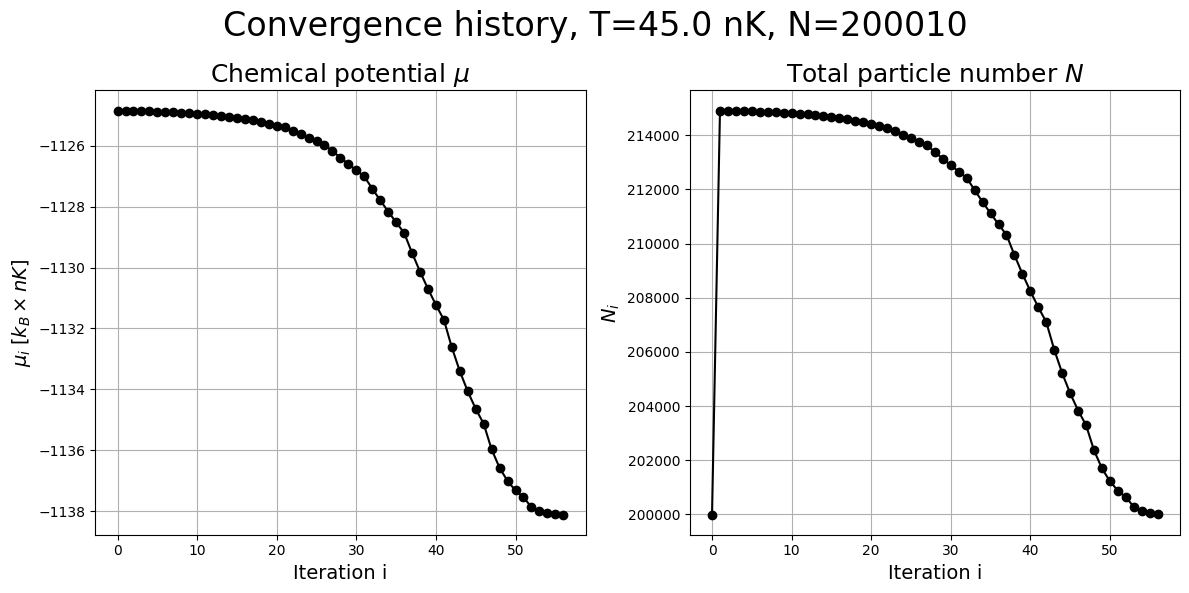

In [23]:
fg.plot_convergence_history()

In [22]:
bec = BoseGas(na23_harmonic)
bec.eval_density()

  0%|          | 1/1000 [00:07<2:03:22,  7.41s/it]


KeyboardInterrupt: 

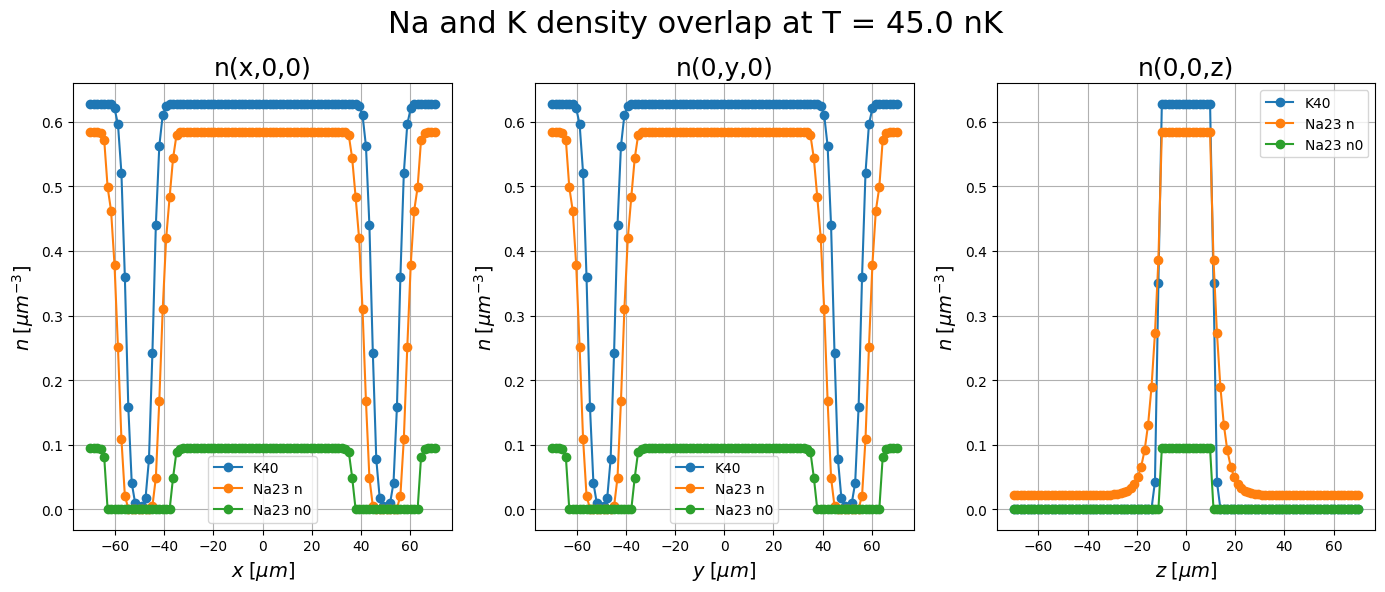

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(14,6))
fig.suptitle("Na and K density overlap at T = " + str(na23_harmonic.T), fontsize=22)

axs[0].plot(fg.x, fg.n_array[:,fg.num_grid_points[1]//2,fg.num_grid_points[2]//2], label="K40", marker="o")
axs[0].plot(bec.x, bec.n_array[:,bec.num_grid_points[1]//2,bec.num_grid_points[2]//2], label="Na23 n", marker="o")
axs[0].plot(bec.x, bec.n0_array[:,bec.num_grid_points[1]//2,bec.num_grid_points[2]//2], label="Na23 n0", marker="o")
axs[0].set_title(r"n(x,0,0)", fontsize=18)
axs[0].set_xlabel(r"$x \; [\mu m]$", fontsize=14)
axs[0].set_ylabel(r"$n \; [\mu m^{-3}]$", fontsize=14)
axs[0].grid(True)
axs[0].legend()

axs[1].plot(fg.y, fg.n_array[fg.num_grid_points[0]//2,:,fg.num_grid_points[2]//2], label="K40", marker="o")
axs[1].plot(bec.y, bec.n_array[bec.num_grid_points[0]//2,:,bec.num_grid_points[2]//2], label="Na23 n", marker="o")
axs[1].plot(bec.y, bec.n0_array[bec.num_grid_points[0]//2,:,bec.num_grid_points[2]//2], label="Na23 n0", marker="o")
axs[1].set_title(r"n(0,y,0)", fontsize=18)
axs[1].set_xlabel(r"$y \; [\mu m]$", fontsize=14)
axs[1].set_ylabel(r"$n \; [\mu m^{-3}]$", fontsize=14)
axs[1].grid(True)
axs[1].legend()

axs[2].plot(fg.z, fg.n_array[fg.num_grid_points[0]//2,fg.num_grid_points[1]//2, :], label="K40", marker="o")
axs[2].plot(bec.z, bec.n_array[bec.num_grid_points[0]//2,bec.num_grid_points[1]//2, :], label="Na23 n", marker="o")
axs[2].plot(bec.z, bec.n0_array[bec.num_grid_points[0]//2,bec.num_grid_points[1]//2, :], label="Na23 n0", marker="o")
axs[2].set_title(r"n(0,0,z)", fontsize=18)
axs[2].set_xlabel(r"$z \; [\mu m]$", fontsize=14)
axs[2].set_ylabel(r"$n \; [\mu m^{-3}]$", fontsize=14)
axs[2].grid(True)
axs[2].legend()

fig.tight_layout()

In [ ]:
bec.condensate_fraction

<Quantity 0.0738234>

In [ ]:
na23_harmonicT0 = na23_harmonic.copy()
na23_harmonicT0.T = 0*u.nK
k40_harmonicT0 = k40_harmonic.copy()
k40_harmonicT0.T = 0*u.nK

In [ ]:
fgT0 = FermiGas(k40_harmonicT0, num_grid_points=101)
fgT0.eval_density(num_q_values=101)

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▍         | 47/1000 [00:01<00:32, 29.77it/s]

Convergence reached after 47 iterations.


In [ ]:
becT0 = BEC(na23_harmonicT0, num_grid_points=101)
becT0.eval_density(num_q_values=101)

NameError: name 'BEC' is not defined

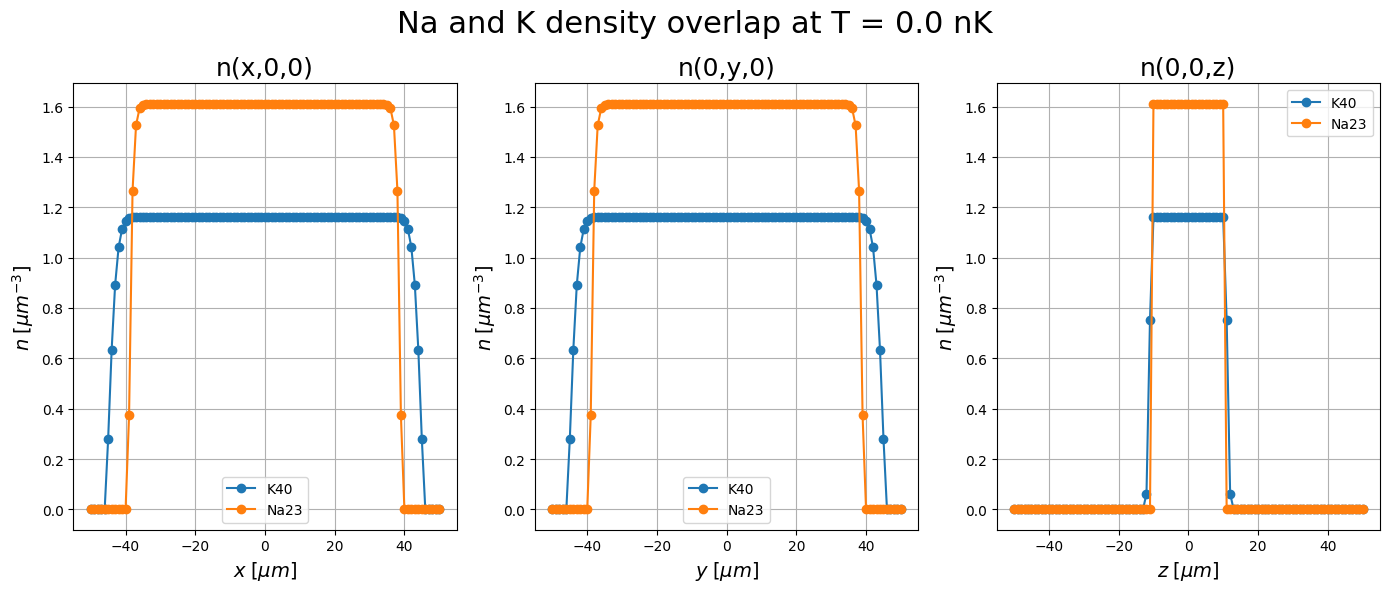

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(14,6))
fig.suptitle("Na and K density overlap at T = " + str(na23_harmonicT0.T), fontsize=22)

axs[0].plot(fgT0.x, fgT0.n_array[:,fgT0.num_grid_points[1]//2,fgT0.num_grid_points[2]//2], label="K40", marker="o")
axs[0].plot(becT0.x, becT0.n_array[:,bec.num_grid_points[1]//2,bec.num_grid_points[2]//2], label="Na23", marker="o")
axs[0].set_title(r"n(x,0,0)", fontsize=18)
axs[0].set_xlabel(r"$x \; [\mu m]$", fontsize=14)
axs[0].set_ylabel(r"$n \; [\mu m^{-3}]$", fontsize=14)
axs[0].grid(True)
axs[0].legend()

axs[1].plot(fgT0.y, fgT0.n_array[fgT0.num_grid_points[0]//2,:,fgT0.num_grid_points[2]//2], label="K40", marker="o")
axs[1].plot(becT0.y, becT0.n_array[bec.num_grid_points[0]//2,:,bec.num_grid_points[2]//2], label="Na23", marker="o")
axs[1].set_title(r"n(0,y,0)", fontsize=18)
axs[1].set_xlabel(r"$y \; [\mu m]$", fontsize=14)
axs[1].set_ylabel(r"$n \; [\mu m^{-3}]$", fontsize=14)
axs[1].grid(True)
axs[1].legend()

axs[2].plot(fgT0.z, fgT0.n_array[fgT0.num_grid_points[0]//2,fgT0.num_grid_points[1]//2, :], label="K40", marker="o")
axs[2].plot(becT0.z, becT0.n_array[bec.num_grid_points[0]//2,bec.num_grid_points[1]//2, :], label="Na23", marker="o")
axs[2].set_title(r"n(0,0,z)", fontsize=18)
axs[2].set_xlabel(r"$z \; [\mu m]$", fontsize=14)
axs[2].set_ylabel(r"$n \; [\mu m^{-3}]$", fontsize=14)
axs[2].grid(True)
axs[2].legend()

fig.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 38/1000 [00:01<00:41, 22.91it/s]


Convergence reached after 38 iterations.


  3%|▎         | 32/1000 [01:52<56:39,  3.51s/it] 


Convergence reached after 32 iterations.


  3%|▎         | 32/1000 [01:52<56:57,  3.53s/it]


Convergence reached after 32 iterations.


  4%|▍         | 38/1000 [02:16<57:30,  3.59s/it]  


Convergence reached after 38 iterations.


  3%|▎         | 31/1000 [01:56<1:00:41,  3.76s/it]

Convergence reached after 31 iterations.



/home/lelo/Dokumente/lightmat/quantum_statistics/analyze_gas.py:217: RuntimeWarning: divide by zero encountered in power
  return 1 - (T / T_c)**alpha


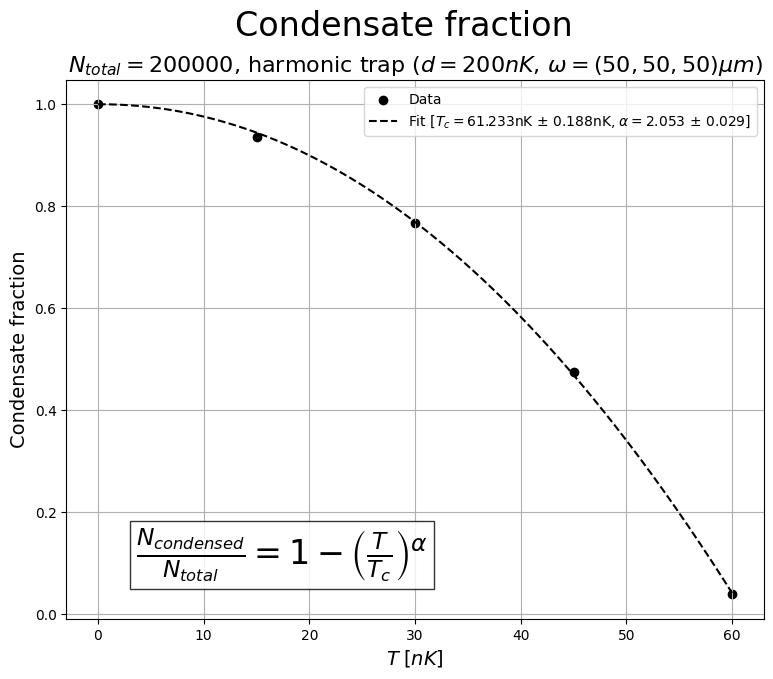

In [ ]:
na23_harmonic = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=200000,
    T=40*u.nK,
    a_s=2.75*u.nm,
    domain=(-50, 50)*u.um,
    #V_trap=harmonic_trap,
    #V_trap=box_trap,
    #V_trap=box_2d_harmonic_1d_trap,
    #trap_depth=100,
    #box_width=(100,100,100),
    #waist=50,
    V_trap=ring_beam_trap,
    flat_sizes=(100, 100, 20)*u.um,
    boundary_waists=(6, 6, 13)*u.um,
    blue_trap_hight=3*100*u.nK,
    red_trap_depth=100*u.nK,
    inhomogenity=0,
)

Ts = np.linspace(0, 60, 5)*u.nK
becs = analyze_bec(Ts, na23_harmonic)
plot_condens_frac(Ts, becs)